In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# DATA PROCESSING

In [4]:
def load_text(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read().lower()
    return text

def build_vocab(text):
    chars = sorted(list(set(text)))
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for ch, i in stoi.items()}
    return chars, stoi, itos

def encode_text(text, stoi):
    return [stoi[c] for c in text]

def create_sequences(encoded, seq_len, max_samples=5000):
    inputs, targets = [], []
    for i in range(0, len(encoded) - seq_len):
        inputs.append(encoded[i:i+seq_len])
        targets.append(encoded[i+1:i+seq_len+1])
    return torch.tensor(inputs[:max_samples]), torch.tensor(targets[:max_samples])


# LSTM MODEL

In [5]:
class LSTMTextGen(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)             # [B, T] -> [B, T, E]
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)            # [B, T, vocab]
        return out, hidden

# TRAINING THE MODEL

In [6]:
def train(model, x, y, vocab_size, epochs=20, batch_size=64, lr=0.005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        for i in range(0, x.size(0), batch_size):
            xb = x[i:i+batch_size]
            yb = y[i:i+batch_size]

            optimizer.zero_grad()
            output, _ = model(xb)
            loss = loss_fn(output.view(-1, vocab_size), yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# Understanding how backprop actually works across layers of a neural network:
1. Backprop in 1 layer 

In [5]:
import numpy as np

np.random.seed(42)
x = np.random.randn(10, 3)
y_true = np.random.randn(10, 1)

w = np.random.randn(3, 1)
b = np.random.randn(1)

learning_rate = 0.01
epochs = 100

for epoch in range(epochs):
    # Forward pass
    y_pred = x @ w + b
    loss = np.mean((y_pred - y_true)**2)
    
    # Backward pass
    n = x.shape[0]
    dL_dy_pred = 2 * (y_pred - y_true) / n
    grad_w = x.T @ dL_dy_pred
    grad_b = np.sum(dL_dy_pred)
    
    # Update parameters
    w -= learning_rate * grad_w
    b -= learning_rate * grad_b
    
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 1.1067
Epoch 2, Loss: 1.0897
Epoch 3, Loss: 1.0733
Epoch 4, Loss: 1.0574
Epoch 5, Loss: 1.0421
Epoch 6, Loss: 1.0272
Epoch 7, Loss: 1.0128
Epoch 8, Loss: 0.9989
Epoch 9, Loss: 0.9854
Epoch 10, Loss: 0.9724
Epoch 11, Loss: 0.9597
Epoch 12, Loss: 0.9474
Epoch 13, Loss: 0.9356
Epoch 14, Loss: 0.9241
Epoch 15, Loss: 0.9129
Epoch 16, Loss: 0.9021
Epoch 17, Loss: 0.8915
Epoch 18, Loss: 0.8814
Epoch 19, Loss: 0.8715
Epoch 20, Loss: 0.8618
Epoch 21, Loss: 0.8525
Epoch 22, Loss: 0.8435
Epoch 23, Loss: 0.8347
Epoch 24, Loss: 0.8261
Epoch 25, Loss: 0.8178
Epoch 26, Loss: 0.8097
Epoch 27, Loss: 0.8018
Epoch 28, Loss: 0.7942
Epoch 29, Loss: 0.7867
Epoch 30, Loss: 0.7795
Epoch 31, Loss: 0.7725
Epoch 32, Loss: 0.7656
Epoch 33, Loss: 0.7589
Epoch 34, Loss: 0.7524
Epoch 35, Loss: 0.7460
Epoch 36, Loss: 0.7399
Epoch 37, Loss: 0.7338
Epoch 38, Loss: 0.7279
Epoch 39, Loss: 0.7222
Epoch 40, Loss: 0.7166
Epoch 41, Loss: 0.7111
Epoch 42, Loss: 0.7058
Epoch 43, Loss: 0.7006
Epoch 44, Loss: 0.69

2. Backprop in 2 layers

In [6]:
import numpy as np

np.random.seed(42)
x = np.random.randn(10, 3)
y_true = np.random.randn(10, 1)

# Layer 1 parameters (input -> hidden)
w1 = np.random.randn(3, 5)  # 3 input features -> 5 hidden units
b1 = np.random.randn(5)

# Layer 2 parameters (hidden -> output)
w2 = np.random.randn(5, 1)  # 5 hidden units -> 1 output
b2 = np.random.randn(1)

learning_rate = 0.01
epochs = 100

for epoch in range(epochs):
    # Forward pass
    z1 = x @ w1 + b1           # Layer 1 linear
    a1 = np.maximum(0, z1)     # ReLU activation
    y_pred = a1 @ w2 + b2      # Layer 2 linear

    #activation can also be done after output layer if required.
    #for binary classification and multi-class classification sigmoid and softmax activation functions may be used respectively

    # Loss (MSE)
    loss = np.mean((y_pred - y_true) ** 2)

    # Backward pass
    n = x.shape[0]
    dL_dy_pred = 2 * (y_pred - y_true) / n   # ∂L/∂y_pred

    # Gradients for Layer 2
    grad_w2 = a1.T @ dL_dy_pred              # ∂L/∂w2
    grad_b2 = np.sum(dL_dy_pred, axis=0)     # ∂L/∂b2

    # Backprop through ReLU and Layer 1
    da1 = dL_dy_pred @ w2.T                  # ∂L/∂a1
    dz1 = da1 * (z1 > 0)                     # ∂a1/∂z1, ReLU derivative

    grad_w1 = x.T @ dz1                      # ∂L/∂w1
    grad_b1 = np.sum(dz1, axis=0)            # ∂L/∂b1

    # Update weights
    w1 -= learning_rate * grad_w1
    b1 -= learning_rate * grad_b1
    w2 -= learning_rate * grad_w2
    b2 -= learning_rate * grad_b2

    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 6.3090
Epoch 2, Loss: 4.6117
Epoch 3, Loss: 3.5406
Epoch 4, Loss: 2.8488
Epoch 5, Loss: 2.3936
Epoch 6, Loss: 2.0889
Epoch 7, Loss: 1.8808
Epoch 8, Loss: 1.7354
Epoch 9, Loss: 1.6310
Epoch 10, Loss: 1.5534
Epoch 11, Loss: 1.4936
Epoch 12, Loss: 1.4457
Epoch 13, Loss: 1.4059
Epoch 14, Loss: 1.3717
Epoch 15, Loss: 1.3409
Epoch 16, Loss: 1.3132
Epoch 17, Loss: 1.2877
Epoch 18, Loss: 1.2639
Epoch 19, Loss: 1.2415
Epoch 20, Loss: 1.2204
Epoch 21, Loss: 1.2002
Epoch 22, Loss: 1.1810
Epoch 23, Loss: 1.1626
Epoch 24, Loss: 1.1450
Epoch 25, Loss: 1.1281
Epoch 26, Loss: 1.1119
Epoch 27, Loss: 1.0963
Epoch 28, Loss: 1.0814
Epoch 29, Loss: 1.0670
Epoch 30, Loss: 1.0533
Epoch 31, Loss: 1.0400
Epoch 32, Loss: 1.0273
Epoch 33, Loss: 1.0150
Epoch 34, Loss: 1.0033
Epoch 35, Loss: 0.9920
Epoch 36, Loss: 0.9811
Epoch 37, Loss: 0.9707
Epoch 38, Loss: 0.9606
Epoch 39, Loss: 0.9510
Epoch 40, Loss: 0.9417
Epoch 41, Loss: 0.9327
Epoch 42, Loss: 0.9241
Epoch 43, Loss: 0.9155
Epoch 44, Loss: 0.90

# TEXT GENERATION FUNCTION

In [11]:
def generate_text(model, stoi, itos, seed_text, length=200):
    model.eval()
    input_seq = torch.tensor([stoi[c] for c in seed_text], dtype=torch.long).unsqueeze(0)
    input_seq = input_seq.to(next(model.parameters()).device)
    
    generated = list(seed_text)
    hidden = None

    for _ in range(length):
        with torch.no_grad():   #no gradient calc during text generation
            output, hidden = model(input_seq, hidden)
            last_logits = output[:, -1, :]
            probs = torch.softmax(last_logits, dim=-1).squeeze()
            next_token = torch.multinomial(probs, 1).item()   #chooses the maximum probability
            generated.append(itos[next_token])

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_token]], device=input_seq.device)], dim=1)

    return ''.join(generated)


In [14]:
def main():
    
    file_path = "/kaggle/input/dataset1/wonderland.txt"  # Adjust if subfolder name differs
    seq_len = 100

    text = load_text(file_path)
    chars, stoi, itos = build_vocab(text)
    encoded = encode_text(text, stoi)
    x, y = create_sequences(encoded, seq_len)

    model = LSTMTextGen(vocab_size=len(chars), embed_dim=64, hidden_dim=128, num_layers=2)
    train(model, x, y, vocab_size=len(chars), epochs=100)

    seed = "alice was sitting "
    print("\nGenerated text:\n")
    print(generate_text(model, stoi, itos, seed, 500))


# Execution of main function

In [15]:
main()

Epoch 1, Loss: 233.6850
Epoch 2, Loss: 199.7909
Epoch 3, Loss: 185.0291
Epoch 4, Loss: 172.0069
Epoch 5, Loss: 159.0534
Epoch 6, Loss: 148.5332
Epoch 7, Loss: 138.6202
Epoch 8, Loss: 128.4745
Epoch 9, Loss: 119.4352
Epoch 10, Loss: 109.3208
Epoch 11, Loss: 101.6040
Epoch 12, Loss: 92.3183
Epoch 13, Loss: 84.4227
Epoch 14, Loss: 74.7700
Epoch 15, Loss: 66.6567
Epoch 16, Loss: 60.9983
Epoch 17, Loss: 54.7744
Epoch 18, Loss: 48.8422
Epoch 19, Loss: 44.4196
Epoch 20, Loss: 40.1792
Epoch 21, Loss: 37.1928
Epoch 22, Loss: 33.2609
Epoch 23, Loss: 29.7717
Epoch 24, Loss: 27.2802
Epoch 25, Loss: 25.3673
Epoch 26, Loss: 23.3631
Epoch 27, Loss: 21.1449
Epoch 28, Loss: 19.6302
Epoch 29, Loss: 18.4177
Epoch 30, Loss: 17.3067
Epoch 31, Loss: 16.4483
Epoch 32, Loss: 14.9463
Epoch 33, Loss: 14.1961
Epoch 34, Loss: 13.4251
Epoch 35, Loss: 12.1566
Epoch 36, Loss: 11.1642
Epoch 37, Loss: 10.2903
Epoch 38, Loss: 9.6050
Epoch 39, Loss: 8.8546
Epoch 40, Loss: 8.3261
Epoch 41, Loss: 7.8904
Epoch 42, Loss: 7.

# Visualizing losses calculated across epochs

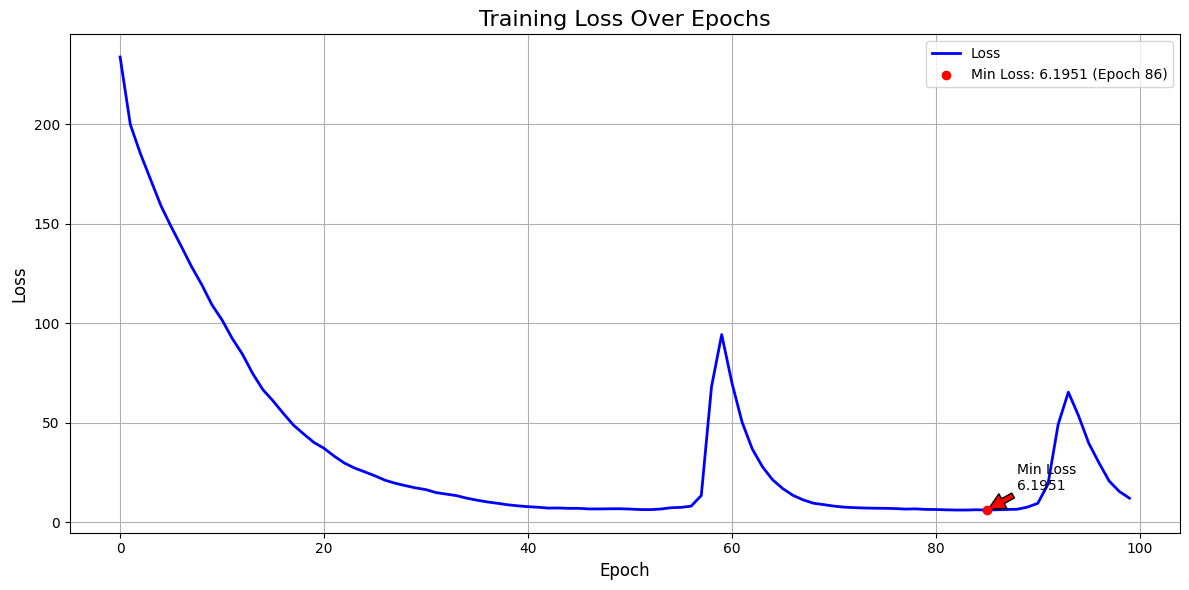

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Paste your loss values
losses = [
    233.6850, 199.7909, 185.0291, 172.0069, 159.0534, 148.5332, 138.6202, 128.4745, 119.4352, 109.3208,
    101.6040, 92.3183, 84.4227, 74.7700, 66.6567, 60.9983, 54.7744, 48.8422, 44.4196, 40.1792,
    37.1928, 33.2609, 29.7717, 27.2802, 25.3673, 23.3631, 21.1449, 19.6302, 18.4177, 17.3067,
    16.4483, 14.9463, 14.1961, 13.4251, 12.1566, 11.1642, 10.2903, 9.6050, 8.8546, 8.3261,
    7.8904, 7.6113, 7.1956, 7.2364, 7.0582, 7.0566, 6.7605, 6.7649, 6.8337, 6.8627,
    6.6937, 6.4618, 6.4188, 6.7087, 7.3485, 7.5436, 8.1535, 13.5047, 68.0379, 94.3250,
    70.1832, 50.3547, 36.8733, 27.9167, 21.3682, 16.9425, 13.5524, 11.2931, 9.6294, 8.9294,
    8.1836, 7.6691, 7.4019, 7.2265, 7.1277, 7.0713, 6.9566, 6.6946, 6.7944, 6.5342,
    6.4780, 6.3210, 6.2091, 6.2143, 6.3529, 6.1951, 6.3533, 6.4978, 6.6135, 7.7019,
    9.5700, 19.1255, 49.1823, 65.3923, 53.5347, 39.7787, 29.9455, 20.7898, 15.5243, 12.1472
]

# Find minimum loss and its epoch
min_loss = min(losses)
min_epoch = losses.index(min_loss) + 1  # +1 to match 1-indexed epochs

# Plot
plt.figure(figsize=(12, 6))
plt.plot(losses, label="Loss", color='blue', linewidth=2)
plt.scatter(min_epoch - 1, min_loss, color='red', label=f"Min Loss: {min_loss:.4f} (Epoch {min_epoch})", zorder=5)
plt.annotate(f"Min Loss\n{min_loss:.4f}", xy=(min_epoch - 1, min_loss), xytext=(min_epoch + 2, min_loss + 10),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)

# Labels and formatting
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Why the loss spikes after 50-55th epoch?
Possible reasons and solutions:
1. during backprop, the gradients might be flowing back across batches->this might result in gradient explosion which in turn leads to instability


   fix->detaching hidden state(hidden states are connected across batches but the gradients dont flow back)
   hidden = model.init_hidden(batch_size)

   for batch in dataset_batches:
    output, hidden = model(batch_input, hidden)  # forward pass
    loss = criterion(output, batch_target)
    loss.backward()                              # backward pass
    optimizer.step()
    optimizer.zero_grad()
    hidden = tuple(h.detach() for h in hidden)

3. gradient explosion due t training across so many epochs


   fix-> gradient clipping(limits (clips) the size of gradients to a maximum threshold, if it increases past this threshold they are scaled down)

   torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

4. for later epochs, lr might be too high. that particular lr was fine for previous epochs as it was needed to converge the model more, but when the model came close to minimum loss the lr might cause spike and may overshoot than the optimum value.


   fix->learning rate scheduler -> lr is updated after certain no of epochs


5. overfitting
    fix->dropout layers

6. bad weight updates(caused by adam optimizer)